## Case de Crédito — Previsão de Inadimplência (OVER60 MOB06)

Estudo e modelagem Preditiva para identificar probabilidade de clientes se tornarem inadimplentes, utilizando informações disponíveis no momento da solicitação.

## 1. Entendimento do Problema

O objetivo deste projeto é construir um modelo preditivo que estime a probabilidade de um cliente tornar-se inadimplente (atraso > 60 dias nos primeiros 6 meses — MOB06) no momento em que solicita um novo crédito.

Este modelo poderá auxiliar na tomada de decisão de concessão de crédito e na definição de limites e preços associados ao risco de cada cliente.

**Problema:** reduzir a inadimplência e melhorar a qualidade dos empréstimos concedidos, identificando clientes com maior probabilidade de risco.

## 2. Entendimento dos dados

Nesta etapa foram carregadas as tabelas disponíveis e exibidas algumas informações gerais, para entender a estrutura, tipos de variáveis e a qualidade dos dados (valores nulos, formatos, tipos de dados).

### 2.1 Pacotes utilizados:

In [615]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [616]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### 2.2 Leitura dos dados:

In [617]:
dicionario = pd.read_csv('dicionario_dados.csv', sep=";")
base_cadastral = pd.read_parquet('base_cadastral.parquet')
base_submissao = pd.read_parquet('base_submissao.parquet')
hist_emprestimos = pd.read_parquet('historico_emprestimos.parquet')
hist_parcelas = pd.read_parquet('historico_parcelas.parquet')


### 2.3 base cadastral

Reúne dados cadastrais dos clientes. Cada linha representa um cliente único (id_cliente).

In [618]:
hist_emprestimos.head()

,id_contrato,id_cliente,tipo_contrato,status_contrato,data_decisao,data_liberacao,data_primeiro_vencimento,data_ultimo_vencimento_original,data_ultimo_vencimento,data_encerramento,...,setor_vendedor,canal_venda,area_venda,dia_semana_solicitacao,hora_solicitacao,flag_ultima_solicitacao_contrato,flag_ultima_solicitacao_dia,motivo_recusa,acompanhantes_cliente,flag_seguro_contratado
0,2802425,108129,Cash loans,Approved,2024-08-29,None,2024-09-28,2027-08-14,None,None,...,XNA,Contact center,-1,THURSDAY,11,Y,1,XAP,Unaccompanied,1.00
1,2330894,258628,Cash loans,Approved,2022-10-11,None,2022-11-10,2024-09-30,2024-08-01,2024-08-04,...,XNA,Credit and cash offices,-1,TUESDAY,15,Y,1,XAP,Unaccompanied,1.00
2,1182516,267782,Cash loans,Approved,2023-04-08,None,2023-05-08,2025-09-24,None,None,...,XNA,Credit and cash offices,-1,SATURDAY,4,Y,1,XAP,None,1.00
3,1543131,275707,Cash loans,Approved,2024-02-08,None,2024-03-09,2025-02-02,2025-02-02,2025-02-09,...,XNA,Credit and cash offices,-1,THURSDAY,8,Y,1,XAP,Unaccompanied,1.00
4,2261993,299391,Revolving loans,Canceled,2024-09-06,None,None,None,None,None,...,XNA,Credit and cash offices,-1,FRIDAY,13,Y,1,XAP,None,NaN


In [619]:
%%capture
hist_emprestimos.info()

In [620]:
hist_emprestimos.describe(include='all').fillna('-')

,id_contrato,id_cliente,tipo_contrato,status_contrato,data_decisao,data_liberacao,data_primeiro_vencimento,data_ultimo_vencimento_original,data_ultimo_vencimento,data_encerramento,...,setor_vendedor,canal_venda,area_venda,dia_semana_solicitacao,hora_solicitacao,flag_ultima_solicitacao_contrato,flag_ultima_solicitacao_dia,motivo_recusa,acompanhantes_cliente,flag_seguro_contratado
count,186890.00,186890.00,186890,186890,186890,7100,107145,101143,87778,86087,...,186890,186890,186890.00,186890,186890.00,186890,186890.00,186890,94786,111691.00
unique,-,-,4,4,2940,2112,2906,4471,2828,2463,...,11,8,-,7,-,2,-,9,7,-
top,-,-,Cash loans,Approved,2024-06-26,2024-07-06,2024-03-22,2025-02-20,2024-04-18,2024-09-01,...,XNA,Credit and cash offices,-,TUESDAY,-,Y,-,XAP,Unaccompanied,-
freq,-,-,83546,116182,301,19,118,96,90,425,...,95776,80376,-,28459,-,185979,-,151948,56618,-
mean,1925411.15,278440.00,-,-,-,-,-,-,-,-,...,-,-,304.10,-,12.47,-,1.00,-,-,0.33
std,532202.08,102686.99,-,-,-,-,-,-,-,-,...,-,-,1600.38,-,3.33,-,0.06,-,-,0.47
min,1000003.00,100023.00,-,-,-,-,-,-,-,-,...,-,-,-1.00,-,0.00,-,0.00,-,-,0.00
25%,1465414.25,189807.00,-,-,-,-,-,-,-,-,...,-,-,-1.00,-,10.00,-,1.00,-,-,0.00
50%,1925815.00,278614.50,-,-,-,-,-,-,-,-,...,-,-,3.00,-,12.00,-,1.00,-,-,0.00
75%,2385854.00,367186.00,-,-,-,-,-,-,-,-,...,-,-,84.00,-,15.00,-,1.00,-,-,1.00


In [621]:
round((base_cadastral.isnull().sum()/len(base_cadastral)) * 100, 2).map(lambda x: f"{x}%")

id_cliente                      0.0%
sexo                            0.0%
data_nascimento                 0.0%
qtd_filhos                      0.0%
qtd_membros_familia             0.0%
renda_anual                     0.0%
tipo_renda                      0.0%
ocupacao                      31.69%
tipo_organizacao                0.0%
nivel_educacao                  0.0%
estado_civil                    0.0%
tipo_moradia                    0.0%
possui_carro                    0.0%
possui_imovel                   0.0%
nota_regiao_cliente             0.0%
nota_regiao_cliente_cidade      0.0%
dtype: object

### 2.4 historico emprestimos

Apresenta o histórico de contratos anteriores realizados por cada cliente. Cada linha representa um contrato específi co (id_contrato) vinculado a um cliente (id_cliente). Um cliente pode ter múltiplos contratos.

In [622]:
%%capture
hist_emprestimos.head()

In [623]:
hist_emprestimos.describe(include='all').fillna('-')

,id_contrato,id_cliente,tipo_contrato,status_contrato,data_decisao,data_liberacao,data_primeiro_vencimento,data_ultimo_vencimento_original,data_ultimo_vencimento,data_encerramento,...,setor_vendedor,canal_venda,area_venda,dia_semana_solicitacao,hora_solicitacao,flag_ultima_solicitacao_contrato,flag_ultima_solicitacao_dia,motivo_recusa,acompanhantes_cliente,flag_seguro_contratado
count,186890.00,186890.00,186890,186890,186890,7100,107145,101143,87778,86087,...,186890,186890,186890.00,186890,186890.00,186890,186890.00,186890,94786,111691.00
unique,-,-,4,4,2940,2112,2906,4471,2828,2463,...,11,8,-,7,-,2,-,9,7,-
top,-,-,Cash loans,Approved,2024-06-26,2024-07-06,2024-03-22,2025-02-20,2024-04-18,2024-09-01,...,XNA,Credit and cash offices,-,TUESDAY,-,Y,-,XAP,Unaccompanied,-
freq,-,-,83546,116182,301,19,118,96,90,425,...,95776,80376,-,28459,-,185979,-,151948,56618,-
mean,1925411.15,278440.00,-,-,-,-,-,-,-,-,...,-,-,304.10,-,12.47,-,1.00,-,-,0.33
std,532202.08,102686.99,-,-,-,-,-,-,-,-,...,-,-,1600.38,-,3.33,-,0.06,-,-,0.47
min,1000003.00,100023.00,-,-,-,-,-,-,-,-,...,-,-,-1.00,-,0.00,-,0.00,-,-,0.00
25%,1465414.25,189807.00,-,-,-,-,-,-,-,-,...,-,-,-1.00,-,10.00,-,1.00,-,-,0.00
50%,1925815.00,278614.50,-,-,-,-,-,-,-,-,...,-,-,3.00,-,12.00,-,1.00,-,-,0.00
75%,2385854.00,367186.00,-,-,-,-,-,-,-,-,...,-,-,84.00,-,15.00,-,1.00,-,-,1.00


In [624]:
round((hist_emprestimos.isnull().sum()/len(hist_emprestimos)) * 100, 2).map(lambda x: f"{x}%")

id_contrato                           0.0%
id_cliente                            0.0%
tipo_contrato                         0.0%
status_contrato                       0.0%
data_decisao                          0.0%
data_liberacao                       96.2%
data_primeiro_vencimento            42.67%
data_ultimo_vencimento_original     45.88%
data_ultimo_vencimento              53.03%
data_encerramento                   53.94%
valor_solicitado                      0.0%
valor_credito                         0.0%
valor_bem                           23.24%
valor_parcela                       22.35%
valor_entrada                        53.6%
percentual_entrada                   53.6%
qtd_parcelas_planejadas             22.35%
taxa_juros_padrao                   99.66%
taxa_juros_promocional              99.66%
tipo_pagamento                        0.0%
finalidade_emprestimo                 0.0%
tipo_cliente                          0.0%
faixa_rendimento                      0.0%
tipo_portfo

*Valores nulos:* <ab>

Data liberação: Sugere muitas propostas que foram aprovadas ou recusadas, mas não foram convertidas. <ab>

Datas de vencimento: Só existem essas datas para contratos que foram formalizados. Porém como há menos nulos que "data_liberacao", pode ser que o sistema gere um cronograma previsto antes de finalizar o contrato. <ab>

Data encerramento: Representam a carteira ativa, ou seja, cliente que estão pagando suas parcelas, assim não possuindo data de encerramento registrada. <ab>

Entradas: Contratos realizados com 100% de financiamento. <ab>

Taxa de juros: Sugere que são dados sensíveis.

### 2.5 histórico parcelas

Detalha os pagamentos realizados para cada contrato. Cada linha representa uma parcela paga de um contrato, vinculada tanto ao id_contrato quanto ao id_cliente.

In [625]:
hist_parcelas.head()

,id_contrato,id_cliente,versao_parcela,numero_parcela,data_prevista_pagamento,data_real_pagamento,valor_previsto_parcela,valor_pago_parcela
0,1594684,100193,0.00,56,2021-12-21,2021-12-21,301.86,301.86
1,1995642,134723,1.00,38,2021-08-09,2021-08-04,12949.20,12949.20
2,1720935,176364,1.00,9,2024-03-06,2024-03-04,61192.53,61192.53
3,1439208,154898,1.00,20,2024-08-11,2024-08-07,8851.23,8851.23
4,1640082,172575,1.00,4,2022-11-15,2022-11-10,8720.28,8720.28


In [626]:
%%capture
hist_parcelas.info()

In [627]:
hist_parcelas.describe(include='all').fillna('-')

,id_contrato,id_cliente,versao_parcela,numero_parcela,data_prevista_pagamento,data_real_pagamento,valor_previsto_parcela,valor_pago_parcela
count,1390978.00,1390978.00,1390978.00,1390978.00,1390978,1390639,1390978.00,1390639.00
unique,-,-,-,-,2910,2923,-,-
top,-,-,-,-,2024-07-22,2024-10-21,-,-
freq,-,-,-,-,1250,1593,-,-
mean,1908259.12,278845.69,0.93,14.92,-,-,18145.87,18353.37
std,535193.18,102181.63,1.06,20.90,-,-,52183.44,56500.72
min,1000003.00,100023.00,0.00,1.00,-,-,0.00,0.00
25%,1437671.00,191166.00,1.00,4.00,-,-,4677.16,4106.93
50%,1902062.00,279270.00,1.00,8.00,-,-,9300.58,8980.25
75%,2371329.00,367159.00,1.00,15.00,-,-,17902.58,17246.92


In [628]:
round((hist_parcelas.isnull().sum()/len(hist_parcelas)) * 100, 2).map(lambda x: f"{x}%")

id_contrato                 0.0%
id_cliente                  0.0%
versao_parcela              0.0%
numero_parcela              0.0%
data_prevista_pagamento     0.0%
data_real_pagamento        0.02%
valor_previsto_parcela      0.0%
valor_pago_parcela         0.02%
dtype: object

### 2.6 base submissão

Contém os contratos de crédito que estão em análise no momento, e para os quais o modelo deverá gerar previsões de inadimplência. Cada linha representa o contrato mais recente de um cliente, identificado por id_cliente.

In [629]:
base_submissao.head()

,id_cliente,data_solicitacao,dia_semana_solicitacao,hora_solicitacao,tipo_contrato,valor_credito,valor_bem,valor_parcela
0,100023,2025-02-24,MONDAY,12,Cash loans,544491.00,454500.00,17563.50
1,100031,2025-02-17,MONDAY,9,Cash loans,979992.00,702000.00,27076.50
2,100056,2025-02-20,THURSDAY,10,Cash loans,1506816.00,1350000.00,49927.50
3,100069,2025-02-10,MONDAY,11,Cash loans,640458.00,517500.00,27265.50
4,100085,2025-02-19,WEDNESDAY,12,Cash loans,755190.00,675000.00,28894.50


In [630]:
%%capture
base_submissao.info()

In [631]:
base_submissao.describe(include='all').fillna('-')

,id_cliente,data_solicitacao,dia_semana_solicitacao,hora_solicitacao,tipo_contrato,valor_credito,valor_bem,valor_parcela
count,40000.00,40000,40000,40000.00,40000,40000.00,39976.00,39996.00
unique,-,21,7,-,2,-,-,-
top,-,2025-02-11,TUESDAY,-,Cash loans,-,-,-
freq,-,2448,7231,-,36599,-,-,-
mean,278414.66,-,-,12.03,-,586259.67,526968.20,27376.03
std,102575.20,-,-,3.27,-,395313.88,363020.87,14750.17
min,100023.00,-,-,0.00,-,45000.00,40500.00,2295.00
25%,190486.25,-,-,10.00,-,270000.00,238500.00,16681.50
50%,277796.50,-,-,12.00,-,502497.00,450000.00,25060.50
75%,367312.25,-,-,14.00,-,791861.62,675000.00,34781.62


In [632]:
round((base_submissao.isnull().sum()/len(base_submissao)) * 100, 2).map(lambda x: f"{x}%")

id_cliente                 0.0%
data_solicitacao           0.0%
dia_semana_solicitacao     0.0%
hora_solicitacao           0.0%
tipo_contrato              0.0%
valor_credito              0.0%
valor_bem                 0.06%
valor_parcela             0.01%
dtype: object

## 3. Preparação dos dados

### 3.1 base cadastral

Nesta etapa tratamos dados cadastrais, corrigindo nulos, agrupando categorias raras e transformando variáveis brutas em indicadores úteis.

In [633]:
# Criando variável: Idade
base_cadastral['idade'] = (pd.to_datetime('today') - pd.to_datetime(base_cadastral['data_nascimento'])).dt.days // 365
base_cadastral.drop("data_nascimento", axis = 1, inplace=True)

In [634]:
# Tratando N/A
base_cadastral['ocupacao'] = base_cadastral['ocupacao'].fillna('N/A')

In [635]:
# Calculos
base_cadastral['proporcao_filhos_familia'] = (base_cadastral['qtd_filhos'] / base_cadastral['qtd_membros_familia']).replace([np.inf, np.nan], 0)
base_cadastral['log_renda_anual'] = np.log1p(base_cadastral['renda_anual'])

In [636]:
# Flags
base_cadastral['possui_carro'] = (base_cadastral['possui_carro'] == 'Y').astype(int)
base_cadastral['possui_imovel'] = (base_cadastral['possui_imovel'] == 'Y').astype(int)
base_cadastral['tem_filhos'] = (base_cadastral['qtd_filhos'] > 0).astype(int)

In [637]:
# Agrupamento de categorias com baixa ocorrência
cat_cols =  ['ocupacao','tipo_renda']

for col in cat_cols:
    freq = base_cadastral[col].value_counts(normalize=True)
    rare = freq[freq < 0.01].index
    base_cadastral[col] = base_cadastral[col].replace(rare, 'Outros')

In [638]:
# Ajustando categorias com baixa ocorrência para classe já existente
freq_organizacao = base_cadastral['tipo_organizacao'].value_counts(normalize=True)
rare_organizaca = freq_organizacao[freq_organizacao < 0.01].index

base_cadastral['tipo_organizacao'] = base_cadastral['tipo_organizacao'].replace(rare_organizaca, 'Other')

In [639]:
# Diminuindo dimensionalidade das categorias
base_cadastral['tipo_moradia'] = base_cadastral['tipo_moradia'].replace({'Office apartment': 'Outros', 'Co-op apartment': 'Outros'})

### 3.2 histórico emprestimos

Variáveis de comportamento financeiro como tempo de aprovação, duração contratual e flags de seguro contratado podem refletir o perfil de risco do cliente. Nulos foram tratados com flags correspondentes.

Variáveis como 'status_contrato', 'motivo_recusa' e 'data_encerramento' foram excluídas por refletirem informações disponíveis apenas após a decisão de crédito, caracterizando vazamento de informação (data leakage). A variável 'data_ultimo_vencimento' foi utilizada de forma agregada para cálculo de duração de contrato, dessa forma não gerando data leaked.


In [640]:
# Tratando as variáveis de data
date_cols = ['data_liberacao', 'data_primeiro_vencimento',
    'data_ultimo_vencimento_original', 'data_ultimo_vencimento',
    'data_encerramento']

for col in date_cols:
    hist_emprestimos[col] = pd.to_datetime(hist_emprestimos[col], errors='coerce')

In [641]:
# criando flags de missing 
num_cols = ['valor_bem','valor_parcela','valor_entrada',
    'percentual_entrada','qtd_parcelas_planejadas',
    'taxa_juros_padrao','taxa_juros_promocional']

for col in num_cols:
    hist_emprestimos[f'{col}_missing'] = hist_emprestimos[col].isna().astype(int)

# Inputando 0 nas variáveis númericas
hist_emprestimos[num_cols] = hist_emprestimos[num_cols].fillna(0)

In [642]:
# Tratando N/A
hist_emprestimos['combinacao_produto'] = (hist_emprestimos['combinacao_produto'].fillna('N/A'))
hist_emprestimos['acompanhantes_cliente'] = (hist_emprestimos['acompanhantes_cliente'].fillna('N/A'))

In [643]:
# Flags
hist_emprestimos['flag_cronograma_definido'] = (hist_emprestimos['data_primeiro_vencimento'].notna().astype(int))

hist_emprestimos['flag_liberado'] = hist_emprestimos['data_liberacao'].notna().astype(int)

hist_emprestimos['flag_seguro_info_disponivel'] = (hist_emprestimos['flag_seguro_contratado'].notna().astype(int))

hist_emprestimos['flag_seguro_contratado'] = (hist_emprestimos['flag_seguro_contratado'].fillna(0).astype(int))


In [644]:
# Cálculos
hist_emprestimos['duracao_contrato_dias'] = (hist_emprestimos['data_ultimo_vencimento'] - hist_emprestimos['data_primeiro_vencimento']).dt.days
hist_emprestimos['duracao_contrato_dias'] = (hist_emprestimos['duracao_contrato_dias'].fillna(0))

hist_emprestimos['tempo_decisao_liberacao'] = (hist_emprestimos['data_liberacao'] - pd.to_datetime(hist_emprestimos['data_decisao'])).dt.days
hist_emprestimos['tempo_decisao_liberacao'] = (hist_emprestimos['tempo_decisao_liberacao'].fillna(0))

hist_emprestimos['pct_valor_entrada'] = (hist_emprestimos['valor_entrada'] / hist_emprestimos['valor_credito']).replace([np.inf, np.nan], 0)

hist_emprestimos['parcela_credito_ratio'] = (hist_emprestimos['valor_parcela'] / hist_emprestimos['valor_credito']).replace([np.inf, np.nan], 0)

hist_emprestimos['log_valor_credito'] = np.log1p(hist_emprestimos['valor_credito'])

In [645]:
# Feature data
hist_emprestimos['hora_solicitacao_bin'] = pd.cut(
    hist_emprestimos['hora_solicitacao'],
    bins=[0,6,12,18,24],
    labels=['madrugada','manha','tarde','noite'],
    right=False
)

In [646]:
# Agrupamento de categorias com baixa ocorrência
cat_cols = ['categoria_bem','finalidade_emprestimo','canal_venda','area_venda', 'setor_vendedor']

for col in cat_cols:
    freq = hist_emprestimos[col].value_counts(normalize=True)
    rare = freq[freq < 0.01].index
    hist_emprestimos[col] = hist_emprestimos[col].replace(rare, 'Outros')


In [647]:
# Diminuindo dimensionalidade das categorias
hist_emprestimos['acompanhantes_cliente'] = (hist_emprestimos['acompanhantes_cliente'].replace({'Other_A': 'Outros', 'Other_B': 'Outros', 'Group of people' : 'Outros'}))

def agrupa_combinacao(x):
    if 'Cash' in x:
        return 'Cash'
    elif 'POS' in x:
        return 'POS'
    elif 'Card' in x:
        return 'Card'
    else:
        return "Outros"
    
hist_emprestimos['combinacao_produto'] = hist_emprestimos['combinacao_produto'].fillna("N/A").apply(agrupa_combinacao)

### 3.3 histórico parcelas

Nesta etapa foram agregados dados de parcelas para medir o comportamento de pagamento ao longo do tempo. Foi calculo métricas como número de parcelas atrasadas, atraso médio e máximo, bem como indicadores de atraso superior a 30 e 60 dias.

As informações do histórico de parcelas foram utilizadas exclusivamente de forma agregada por contrato e restritas até o sexto mês do contrato, sendo assim compatível com a definição da variável target, garantindo que apenas informações disponíveis antes do evento fossem utilizadas.

In [648]:
# Converte datas
date_cols = ['data_prevista_pagamento','data_real_pagamento']

for col in date_cols:
    hist_parcelas[col] = pd.to_datetime(hist_parcelas[col])


# Ajuste da data de pagamento para casos não pagos
data_corte = hist_parcelas['data_prevista_pagamento'].max()
hist_parcelas['data_pagamento_ajustada'] = hist_parcelas['data_real_pagamento'].fillna(data_corte)

# Calcular atraso em dias (pagamento antecipado = 0)
hist_parcelas['atraso_dias'] = (hist_parcelas['data_pagamento_ajustada'] - hist_parcelas['data_prevista_pagamento']).dt.days.clip(lower=0)

In [649]:
# Flags
hist_parcelas['flag_atraso'] = (hist_parcelas['atraso_dias'] > 0).astype(int)

hist_parcelas['atraso_30'] = (hist_parcelas['atraso_dias'] >= 30).astype(int)

hist_parcelas['atraso_60'] = (hist_parcelas['atraso_dias'] >= 60).astype(int)

hist_parcelas['pagamento_parcial'] = (hist_parcelas['valor_pago_parcela'] < hist_parcelas['valor_previsto_parcela']).astype(int)

In [650]:
# Percentual pago
hist_parcelas['pct_pago'] = (hist_parcelas['valor_pago_parcela'] / hist_parcelas['valor_previsto_parcela']).fillna(0)

In [651]:
# Restringindo base à minha variável target (6 primeiros meses - MOB06)
hist_parcelas_6m = hist_parcelas[hist_parcelas['numero_parcela'] <= 6].copy()

In [652]:
# Agregação por contrato
agg_parcelas = hist_parcelas_6m.groupby('id_contrato') \
    .agg(
        qtd_parcelas_6m = ('numero_parcela', 'count'),
        atraso_medio = ('atraso_dias', 'mean'),
        atraso_max = ('atraso_dias', 'max'),
        qtd_parcelas_atraso = ('flag_atraso', 'sum'),
        qtd_atraso_30 = ('atraso_30', 'sum'),
        qtd_atraso_60 = ('atraso_60', 'sum'),
        pct_pago_medio = ('pct_pago', 'mean'),
        qtd_pagamento_parcial = ('pagamento_parcial', 'sum')
).reset_index()

### 3.4 Variável target

A variável target foi inicialmente construída por contrato, definindo como inadimplente contratos com atraso acumulado superior a 60 dias no período MOB06. Em seguida, agregamos a target para o nível de cliente, considerando um cliente como “inadimplente” se pelo menos um dos seus contratos históricos apresentou essa condição. Isso garante consistência com a base de submissão, que está no nível de cliente.


#### 3.4.1 Avaliação de definições de inadimplência

In [653]:
# Primeiras 3 parcelas
parcelas_mob03 = hist_parcelas[
    hist_parcelas['numero_parcela'] <= 3
].copy()

# Flag atraso
parcelas_mob03['flag_atraso_30'] = (
    parcelas_mob03['atraso_dias'] > 30
).astype(int)

# Agregando por contrato
target_ever30 = (
    parcelas_mob03
    .groupby('id_contrato', as_index=False)
    .agg(ever30mob03=('flag_atraso_30', 'max'))
                )

print(f"Distribuição: \n{target_ever30['ever30mob03'].value_counts(normalize=True).map(lambda x: f"{x:.4%}")}")

Distribuição: 
ever30mob03
0    99.7598%
1     0.2402%
Name: proportion, dtype: object


#### A definição EVER30MOB03 foi testada, porém descartada devido à baixa incidência de eventos. 

#### 3.4.2 Construção da variável target

In [654]:
# Soma atraso acumulado por contrato
target_over60 = (
    hist_parcelas_6m
    .groupby('id_contrato', as_index=False)
    .agg(atraso_total_mob06=('atraso_dias', 'sum'))
)

# Flag de inadimplência
target_over60['over60mob06'] = (target_over60['atraso_total_mob06'] > 60).astype(int)

# Distribuição
print(f"Distribuição target: \n{target_over60['over60mob06'].value_counts(normalize=True).map(lambda x: f"{x:.4%}")}")


Distribuição target: 
over60mob06
0    98.8736%
1     1.1264%
Name: proportion, dtype: object


#### A variável target adotada foi a OVER60MOB06, que identifica contratos com mais de 60 dias acumulados de atraso nos seis primeiros meses. A incidência observada foi de 1,13%, indicando um cenário de eventos raros.

#### 3.4.3 Variável target nível cliente

In [655]:
# Trazendo id_cliente a base target
target_over60 = (
    target_over60
    .merge(
        hist_emprestimos[['id_contrato', 'id_cliente']],
        on='id_contrato',
        how='left'
    )
)

# Agrupando por cliente
target_cliente = (
    target_over60
    .groupby('id_cliente', as_index=False)
    .agg(over60mob06=('over60mob06', 'max'))
)

# Distribuição por cliente
print(
    "Distribuição da target (nível cliente):\n",
    target_cliente['over60mob06']
        .value_counts(normalize=True)
        .map(lambda x: f"{x:.4%}")
)


Distribuição da target (nível cliente):
 over60mob06
0    96.9342%
1     3.0658%
Name: proportion, dtype: object


A variável target foi agregada para o nível de cliente, considerando inadimplente o cliente que apresentou pelo menos um contrato com atraso superior a 60 dias nos primeiros seis meses (MOB06).

#### Variáveis que representam eventos ocorridos após a decisão de crédito foram removidas, a fim de evitar vazamento de informação.
#### Foram mantidos apenas contratos com histórico completo de pelo menos seis meses após a concessão, garantindo a correta observação da variável target (inadimplência em MOB06) e evitando rótulos censurados.
#### Com as bases tratadas, agregadas e alinhadas ao nível de cliente, o conjunto de dados está preparado para a análise exploratória orientada à variável target e, posteriormente, para a etapa de modelagem preditiva.

## 4. Análise Exploratória da Inadimplência (Nível de Cliente)

### 4.1 Base cliente

A base foi construída no nível de cliente, utilizando informações disponíveis até o momento da solicitação de crédito (application) e histórico prévio (behavior).

In [656]:
# Construção variaveis behavior emprestimo
hist_emprestimos_prev = (
    hist_emprestimos
    .merge(
        base_submissao[['id_cliente', 'data_solicitacao']],
        on='id_cliente',
        how='inner'
    )
    .query('data_decisao < data_solicitacao')
)

# Variaveis agregadas hist_emprestimos
agg_hist_contratos = (
    hist_emprestimos_prev
    .groupby('id_cliente')
    .agg(
        qtd_contratos_previos = ('id_contrato', 'nunique'),
        qtd_contratos_encerrados = ('data_encerramento', lambda x: x.notna().sum()),
        valor_credito_medio_prev = ('valor_credito', 'mean'),
        valor_credito_max_prev = ('valor_credito', 'max'),
        taxa_juros_media_prev = ('taxa_juros_padrao', 'mean'),
        prazo_medio_prev = ('qtd_parcelas_planejadas', 'mean'),
        flag_teve_recusa = ('status_contrato', lambda x: (x == 'Refused').any())
    )
    .reset_index()
)


In [657]:
# Construção variaveis behavior parcelas
hist_parcelas_prev = (
    hist_parcelas
    .drop(columns=['id_cliente'], errors='ignore')
    .merge(
        hist_emprestimos_prev[['id_contrato', 'id_cliente']],
        on='id_contrato',
        how='inner'
    )
)

# Variaveis agregadas hist_parcelas
agg_hist_parcelas = (
    hist_parcelas_prev
    .groupby('id_cliente')
    .agg(
        qtd_parcelas_prev = ('numero_parcela', 'count'),
        atraso_medio_prev = ('atraso_dias', 'mean'),
        atraso_max_prev = ('atraso_dias', 'max'),
        qtd_atrasos_prev = ('flag_atraso', 'sum'),
        qtd_atraso_30_prev = ('atraso_30', 'sum'),
        qtd_atraso_60_prev = ('atraso_60', 'sum'),
        pct_pago_medio_prev = ('pct_pago', 'mean'),
        flag_ja_inadimplente = ('atraso_60', lambda x: (x > 0).any())
    )
    .reset_index()
)

In [658]:
# Base das variáveis application
df_app = (
    base_submissao
    .merge(
        base_cadastral,
        on='id_cliente',
        how='left'
    )
)

# Juntando as bases
df_model_behavior = (
    df_app
    .merge(agg_hist_contratos, on='id_cliente', how='left')
    .merge(agg_hist_parcelas, on='id_cliente', how='left')
)

# Juntando base + target_cliente
df_model_final = (
    df_model_behavior
    .merge(
        target_cliente,
        on='id_cliente',
        how='left'
    )
)

In [659]:
# Tratamento 
behavior_cols = [
    'qtd_contratos_previos',
    'qtd_contratos_encerrados',
    'valor_credito_medio_prev',
    'valor_credito_max_prev',
    'taxa_juros_media_prev',
    'prazo_medio_prev',
    'flag_teve_recusa',
    'qtd_parcelas_prev',
    'atraso_medio_prev',
    'atraso_max_prev',
    'qtd_atrasos_prev',
    'qtd_atraso_30_prev',
    'qtd_atraso_60_prev',
    'pct_pago_medio_prev',
    'flag_ja_inadimplente'
]

# Criando flags dos missing
for col in behavior_cols:
    df_model_final[f'{col}_missing'] = df_model_final[col].isna().astype(int)

# Valores NA inputados 0
df_model_final[behavior_cols] = df_model_final[behavior_cols].fillna(0)

# Separando a base válida:
df_model_final = df_model_final[df_model_final['over60mob06'].notna()].copy()

### 4.2 Plots relevantes

In [660]:
df_model_final['over60mob06'].value_counts(normalize=True)

over60mob06
0.00   0.97
1.00   0.03
Name: proportion, dtype: float64

Apenas 3% dos clientes apresentam inadimplência, reforçando que se trata de um evento raro, o que influencia escolha de métricas e técnicas de balanceamento na modelagem.

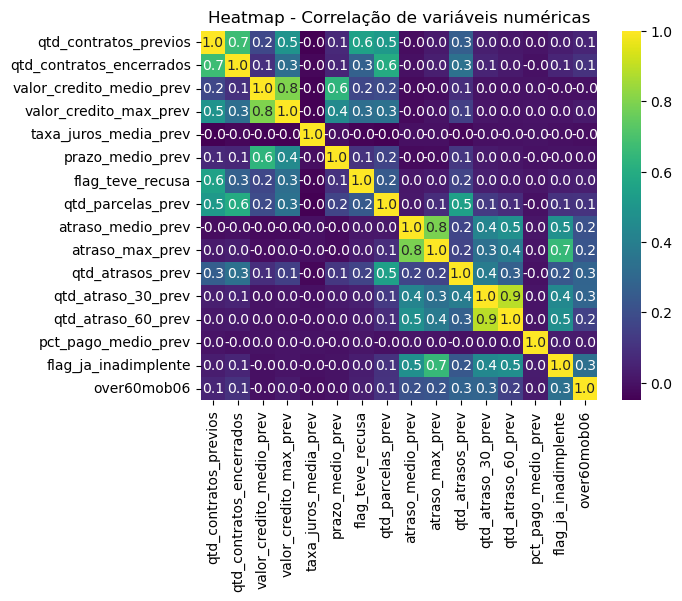

In [661]:
behavior_cols = [
    'qtd_contratos_previos',
    'qtd_contratos_encerrados',
    'valor_credito_medio_prev',
    'valor_credito_max_prev',
    'taxa_juros_media_prev',
    'prazo_medio_prev',
    'flag_teve_recusa',
    'qtd_parcelas_prev',
    'atraso_medio_prev',
    'atraso_max_prev',
    'qtd_atrasos_prev',
    'qtd_atraso_30_prev',
    'qtd_atraso_60_prev',
    'pct_pago_medio_prev',
    'flag_ja_inadimplente'
]

corr = df_model_final[behavior_cols + ['over60mob06']].corr()
sns.heatmap(corr, cmap='viridis', annot=True, fmt='.1f')

plt.title('Heatmap - Correlação de variáveis numéricas')
None

**Hipótese:** Quanto maior a quantidade de membros na família, maior a porcentagem de inadimplência.

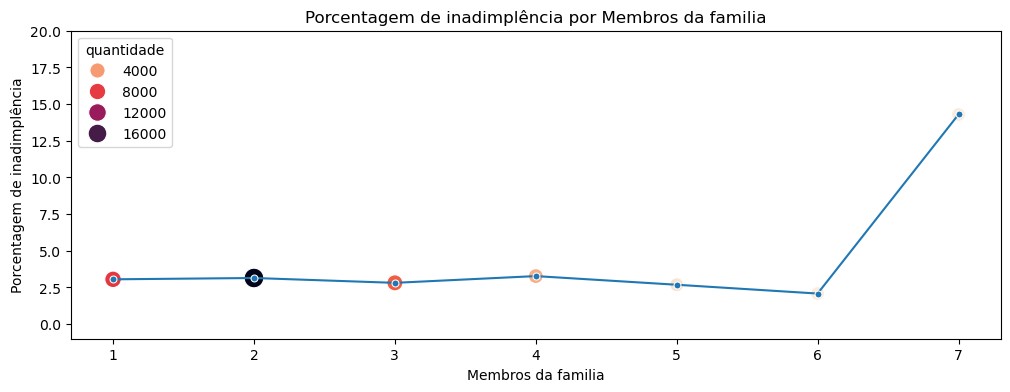

In [662]:
familia_inad = (
    df_model_final.groupby(['over60mob06', 'qtd_membros_familia'], observed=False) \
    .agg(count = pd.NamedAgg(column='qtd_membros_familia', aggfunc='count')) \
    .reset_index() \
    .pivot(index = 'qtd_membros_familia', columns='over60mob06', values= 'count')    
)
familia_inad.reset_index(inplace=True)

# Criando a coluna de quantidade total de ofertas
familia_inad['quantidade'] = familia_inad[0] + familia_inad[1]

familia_inad['Inadimplência_%'] = round((familia_inad[1] / (familia_inad[0] + familia_inad[1]) * 100),2)


# Gráfico
plt.figure(figsize=(12,4))

g = sns.lineplot(data = familia_inad, x= 'qtd_membros_familia', y = 'Inadimplência_%', marker ='o', markersize = 5)

g1 = sns.scatterplot(
    data=familia_inad,
    x='qtd_membros_familia',
    y='Inadimplência_%',
    size='quantidade', 
    sizes=(100, 200),  
    alpha=1,  
    legend=True,  
    hue = 'quantidade',
    palette='rocket_r'
)

# Textos
plt.title('Porcentagem de inadimplência por Membros da familia')
plt.xlabel('Membros da familia')
plt.ylabel('Porcentagem de inadimplência')
plt.ylim(-1,20)
None

Observa-se um aumento de 12.5% na inadimplência para clientes que possuem 7 membros na família por contrato, porém com baixo volume.

**Hipótese:** Quanto mais velha a geração, maior a porcentagem de inadimplência.

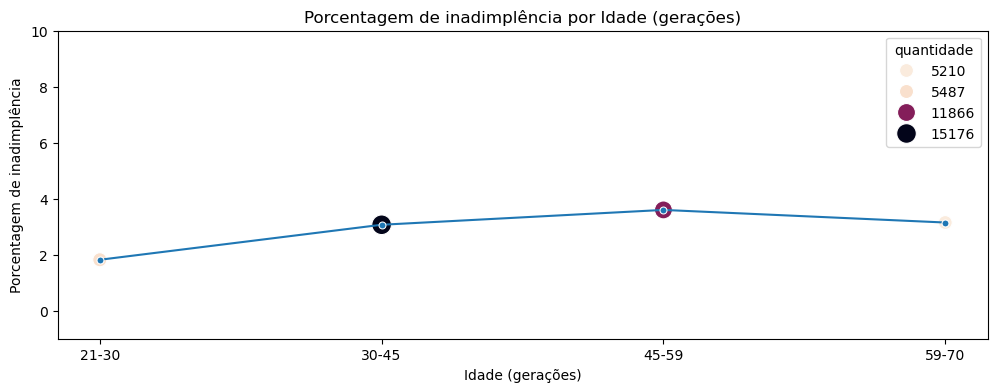

In [663]:
# Nova coluna com os bins (gerações)
bins = [df_model_final['idade'].min(), 30, 45, 59, df_model_final['idade'].max()]
labels = [f'{df_model_final['idade'].min()}-30', '30-45', '45-59', f'59-{df_model_final['idade'].max()}']

df_model_final['idade_bins'] = pd.cut(df_model_final['idade'], bins=bins, labels=labels, right=True, include_lowest=True)

# Tabela Agg
idade_inad = (
    df_model_final.groupby(['over60mob06', 'idade_bins'], observed=False) \
    .agg(count = pd.NamedAgg(column='idade_bins', aggfunc='count')) \
    .reset_index() \
    .pivot(index = 'idade_bins', columns='over60mob06', values= 'count')    
)
idade_inad.reset_index(inplace=True)

# Criando a coluna de quantidade total de ofertas
idade_inad['quantidade'] = idade_inad[0] + idade_inad[1]

idade_inad['Inadimplência_%'] = round((idade_inad[1] / (idade_inad[0] + idade_inad[1]) * 100),2)


# Gráfico
plt.figure(figsize=(12,4))

g = sns.lineplot(data = idade_inad, x= 'idade_bins', y = 'Inadimplência_%', marker ='o', markersize = 5)

g1 = sns.scatterplot(
    data=idade_inad,
    x='idade_bins',
    y='Inadimplência_%',
    size='quantidade', 
    sizes=(100, 200),  
    alpha=1,  
    legend=True,  
    hue = 'quantidade',
    palette='rocket_r'
)

# Textos
plt.title('Porcentagem de inadimplência por Idade (gerações)')
plt.xlabel('Idade (gerações)')
plt.ylabel('Porcentagem de inadimplência')
plt.ylim(-1,10)
None

Observa-se um leve aumento da porcentagem de inadimplência de 3% na geração millennials, subindo para 4% na geração X, onde encontram-se os maiores volumes de clientes, respectivamente. Porém decai levemente na geração baby boomer para 3% de inadimplência.

**Hipótese:** Quanto maior os dias de atraso, maior a porcentagem de inadimplência.

In [664]:
# Nova coluna com os bins (dias de atraso)
bins = [df_model_final['qtd_atrasos_prev'].min(), 1, 2, 3, 4, 5, 6, df_model_final['qtd_atrasos_prev'].max()]
labels = [f'{df_model_final['qtd_atrasos_prev'].min()}-1', '1-2', '2-3', '3-4', '4-5', '5-6', f'> 6']

df_model_final['qtd_atrasos_prev_bins'] = pd.cut(df_model_final['qtd_atrasos_prev'], bins=bins, labels=labels, right=True, include_lowest=True)

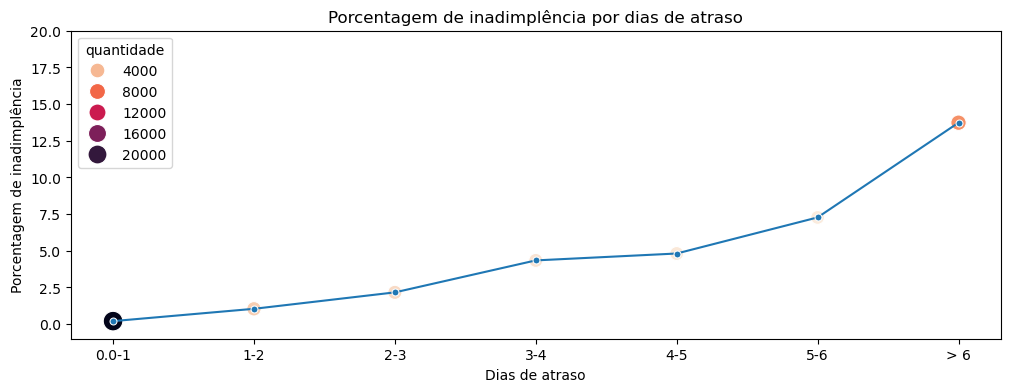

In [665]:
# Tabela agg
atraso_max_inad = (
    df_model_final.groupby(['over60mob06', 'qtd_atrasos_prev_bins'], observed=False) \
    .agg(count = pd.NamedAgg(column='qtd_atrasos_prev_bins', aggfunc='count')) \
    .reset_index() \
    .pivot(index = 'qtd_atrasos_prev_bins', columns='over60mob06', values= 'count')    
)
atraso_max_inad.reset_index(inplace=True)

# Criando a coluna de quantidade total de ofertas
atraso_max_inad['quantidade'] = atraso_max_inad[0] + atraso_max_inad[1]

atraso_max_inad['Inadimplência_%'] = round((atraso_max_inad[1] / (atraso_max_inad[0] + atraso_max_inad[1]) * 100),2)


# Gráfico
plt.figure(figsize=(12,4))

g = sns.lineplot(data =atraso_max_inad, x= 'qtd_atrasos_prev_bins', y = 'Inadimplência_%', marker ='o', markersize = 5)

g1 = sns.scatterplot(
    data=atraso_max_inad,
    x='qtd_atrasos_prev_bins',
    y='Inadimplência_%',
    size='quantidade', 
    sizes=(100, 200),  
    alpha=1,  
    legend=True,  
    hue = 'quantidade',
    palette='rocket_r'
)

# Textos
plt.title('Porcentagem de inadimplência por dias de atraso')
plt.xlabel('Dias de atraso')
plt.ylabel('Porcentagem de inadimplência')
plt.ylim(-1,20)
None

Observa-se como descrito na hipótese, começando a inadimplência próxima a 0% para clientes com 0-1 dia de atraso do contrato, e vai crescendo gradualmente, até 15% de inadimplência para clientes com 6 dias ou mais de atraso do contrato.

**Hipótese:** Quanto menor a porcentagem de pagamento da parcela (em média), maior a porcentagem de inadimplência.

In [666]:
# Nova coluna com os bins (quartis da parcela)
bins = [0, 0.25, 0.5, 0.75, 1, df_model_final['pct_pago_medio_prev'].max()]
labels = [f'0-0.25', '0.25-0.50', '0.50-0.75', '0.75-1', f'>= 1']

df_model_final['pct_pago_medio_prev_bins'] = pd.cut(df_model_final['pct_pago_medio_prev'], bins=bins, labels=labels, right=True, include_lowest=True)

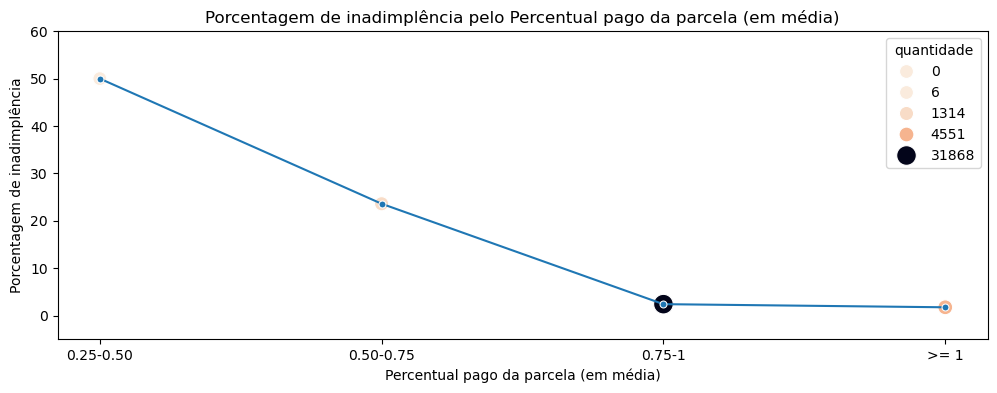

In [667]:
pct_pago_inad = (
    df_model_final.groupby(['over60mob06', 'pct_pago_medio_prev_bins'], observed=False) \
    .agg(count = pd.NamedAgg(column='pct_pago_medio_prev_bins', aggfunc='count')) \
    .reset_index() \
    .pivot(index = 'pct_pago_medio_prev_bins', columns='over60mob06', values= 'count')    
)
pct_pago_inad.reset_index(inplace=True)

# Criando a coluna de quantidade total de ofertas
pct_pago_inad['quantidade'] = pct_pago_inad[0] + pct_pago_inad[1]

pct_pago_inad['Inadimplência_%'] = round((pct_pago_inad[1] / (pct_pago_inad[0] + pct_pago_inad[1]) * 100),2)


# Gráfico
plt.figure(figsize=(12,4))

g = sns.lineplot(data =pct_pago_inad, x= 'pct_pago_medio_prev_bins', y = 'Inadimplência_%', marker ='o', markersize = 5)

g1 = sns.scatterplot(
    data=pct_pago_inad,
    x='pct_pago_medio_prev_bins',
    y='Inadimplência_%',
    size='quantidade', 
    sizes=(100, 200),  
    alpha=1,  
    legend=True,  
    hue = 'quantidade',
    palette='rocket_r'
)

# Textos
plt.title('Porcentagem de inadimplência pelo Percentual pago da parcela (em média)')
plt.xlabel('Percentual pago da parcela (em média)')
plt.ylabel('Porcentagem de inadimplência')
plt.ylim(-5,60)
None

Nota-se o comportamento como descrito na hipótese, quanto menor a porcentagem de pagamento da parcela (em média), maior a porcentagem de inadimplência. Clientes que pagaram entre 0.25%-0.5% da sua parcela do contrato, tem inadimplência de 50%; os que pagaram 0.5%-0.75% da sua parcela do contrato possuem 20% de inadimplência; após isso, os valores se aproximam de 0% de inadimplência.

**Hipótese:** Quanto menor o número de parcelas planejadas por cliente, maior a porcentagem de inadimplência.

In [668]:
# Nova coluna com os bins (anos)
bins = [df_model_final['qtd_parcelas_prev'].min(), 12, 24, 36, 48, 60, 72, df_model_final['qtd_parcelas_prev'].max()]
labels = [f'{df_model_final['qtd_parcelas_prev'].min()}-12', '12-24', '24-36', '36-48', '48-60', '60-72', f' >= 72']

df_model_final['qtd_parcelas_prev_bins'] = pd.cut(df_model_final['qtd_parcelas_prev'], bins=bins, labels=labels, right=True, include_lowest=True)

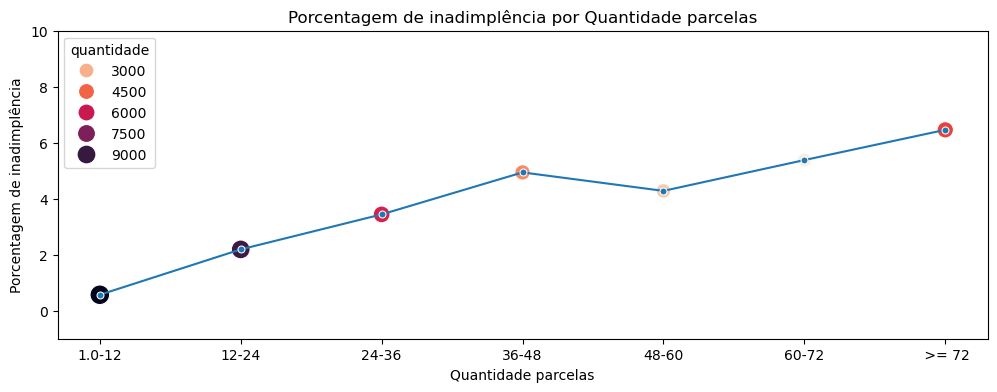

In [669]:
parcelas_plan_inad = (
    df_model_final.groupby(['over60mob06', 'qtd_parcelas_prev_bins'], observed=False) \
    .agg(count = pd.NamedAgg(column='qtd_parcelas_prev_bins', aggfunc='count')) \
    .reset_index() \
    .pivot(index = 'qtd_parcelas_prev_bins', columns='over60mob06', values= 'count')    
)
parcelas_plan_inad.reset_index(inplace=True)

# Criando a coluna de quantidade total de ofertas
parcelas_plan_inad['quantidade'] = parcelas_plan_inad[0] + parcelas_plan_inad[1]

parcelas_plan_inad['Inadimplência_%'] = round((parcelas_plan_inad[1] / (parcelas_plan_inad[0] + parcelas_plan_inad[1]) * 100),2)


# Gráfico
plt.figure(figsize=(12,4))

g = sns.lineplot(data =parcelas_plan_inad, x= 'qtd_parcelas_prev_bins', y = 'Inadimplência_%', marker ='o', markersize = 5)

g1 = sns.scatterplot(
    data=parcelas_plan_inad,
    x='qtd_parcelas_prev_bins',
    y='Inadimplência_%',
    size='quantidade', 
    sizes=(100, 200),  
    alpha=1,  
    legend=True,  
    hue = 'quantidade',
    palette='rocket_r'
)

# Textos
plt.title('Porcentagem de inadimplência por Quantidade parcelas')
plt.xlabel('Quantidade parcelas')
plt.ylabel('Porcentagem de inadimplência')
plt.ylim(-1,10)
None

Nota-se comportamento oposto a hipótese, onde à porcentagem de inadimplência cresce gradualmente até clientes com contrato de 36-48 parcelas, chegando a 5%. Em seguida cai para 4%, e volta a crescer, chegando a 6% para clientes com contratos de 72 parcelas ou mais

**Hipótese:** Clientes que já foram inadimplentes tendem a ter maior porcentagem de inadimplência.

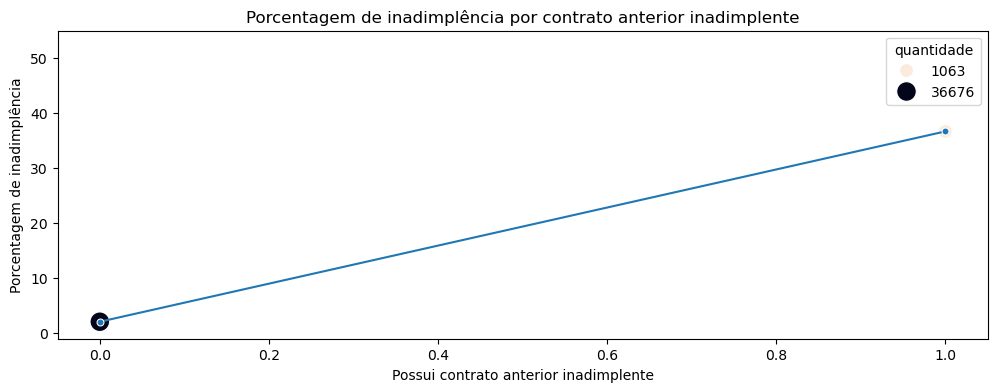

In [670]:
ja_inad_inad = (
    df_model_final.groupby(['over60mob06', 'flag_ja_inadimplente'], observed=False) \
    .agg(count = pd.NamedAgg(column='flag_ja_inadimplente', aggfunc='count')) \
    .reset_index() \
    .pivot(index = 'flag_ja_inadimplente', columns='over60mob06', values= 'count')    
)
ja_inad_inad.reset_index(inplace=True)

# Criando a coluna de quantidade total de ofertas
ja_inad_inad['quantidade'] = ja_inad_inad[0] + ja_inad_inad[1]

ja_inad_inad['Inadimplência_%'] = round((ja_inad_inad[1] / (ja_inad_inad[0] + ja_inad_inad[1]) * 100),2)


# Gráfico
plt.figure(figsize=(12,4))

g = sns.lineplot(data =ja_inad_inad, x= 'flag_ja_inadimplente', y = 'Inadimplência_%', marker ='o', markersize = 5)

g1 = sns.scatterplot(
    data=ja_inad_inad,
    x='flag_ja_inadimplente',
    y='Inadimplência_%',
    size='quantidade', 
    sizes=(100, 200),  
    alpha=1,  
    legend=True,  
    hue = 'quantidade',
    palette='rocket_r'
)

# Textos
plt.title('Porcentagem de inadimplência por contrato anterior inadimplente')
plt.xlabel('Possui contrato anterior inadimplente')
plt.ylabel('Porcentagem de inadimplência')
plt.ylim(-1,55)
None

Confirmando a hipótese, clientes que já tiveram contratos inadimplentes possuem inadimplência de 40%, enquanto clientes que nunca tiveram contratos inadimplentes possuem inadimplência de 2%

## 5. Modelagem

### 5.1 Treino/Teste

In [671]:
# Supondo que a base final se chame df_final e o target 'inadimplente'
X = df_model_final.drop(columns=['over60mob06', 'id_cliente'])
y = df_model_final['over60mob06']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Treino:", X_train.shape, "Teste:", X_test.shape)

Treino: (26417, 59) Teste: (11322, 59)


### 5.2 Pre-processamento

In [673]:
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object', 'category']).columns

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

### 5.3 Regressão logística

In [674]:
logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

logreg.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['hora_solicitacao', 'valor_credito', 'valor_bem', 'valor_parcela',
       'qtd_filhos', 'qtd_membros_familia', 'renda_anual',
       'nota_regiao_cliente', 'nota_regiao_cliente_cidade', 'idade',
       'proporcao...
                                                  Index(['data_solicitacao', 'dia_semana_solicitacao', 'tipo_contrato', 'sexo',
       'tipo_renda', 'ocupacao', 'tipo_organizacao', 'nivel_educacao',
       'estado_civil', 'tipo_moradia', 'flag_teve_recusa',
       'flag_ja_inadimplente', 'idade_bins', 'qtd_atrasos_prev_bins',
       'pct_pago_medio_prev_bins', 'qtd_parcelas_prev_bins'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

### 5.4 XGBoost

In [693]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        eval_metric='auc',
        use_label_encoder=False,
        random_state=42
    ))
])

xgb.fit(X_train, y_train)

c:\Users\lucas\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:48:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['hora_solicitacao', 'valor_credito', 'valor_bem', 'valor_parcela',
       'qtd_filhos', 'qtd_membros_familia', 'renda_anual',
       'nota_regiao_cliente', 'nota_regiao_cliente_cidade', 'idade',
       'proporcao...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [696]:
def avaliar_modelo(model, X_test, y_test, nome_modelo):
    y_pred_proba = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    print(f"{nome_modelo}: ROC-AUC = {roc_auc:.4f}, PR-AUC = {pr_auc:.4f}")

def ks_score(y_true, y_proba, nome_modelo):
    
    # Ordena pelo score
    data = np.vstack([y_proba, y_true]).T
    data = data[np.argsort(data[:,0])]
    
    # CDFs acumuladas
    cum_pos = np.cumsum(data[:,1]) / np.sum(data[:,1])
    cum_neg = np.cumsum(1 - data[:,1]) / np.sum(1 - data[:,1])
    
    # KS
    ks = np.max(np.abs(cum_pos - cum_neg))
    
    print(f"{nome_modelo}: KS = {ks:.4f}")



avaliar_modelo(logreg, X_test, y_test, "Regressão Logística")
ks_score(y_test, logreg.predict_proba(X_test)[:,1], "Regressão Logística")

avaliar_modelo(xgb, X_test, y_test, "XGBoost")
ks_score(y_test, xgb.predict_proba(X_test)[:,1], "XGBoost")

Regressão Logística: ROC-AUC = 0.9547, PR-AUC = 0.3959
Regressão Logística: KS = 0.7800
XGBoost: ROC-AUC = 0.9789, PR-AUC = 0.5374
XGBoost: KS = 0.9051


**ROC-AUC (0.95 e 0.97):**
Mede a capacidade geral do modelo de separar clientes inadimplentes e adimplentes. Valores próximos de 1 indicam excelente discriminação. Ambos os modelos se saíram muito bem, mas o XGBoost é ligeiramente melhor.

**PR-AUC (0.39 e 0.53):**
Mais relevante para evento raro (inadimplência). Mede precisão vs recall.

Logística: 0.3959 → bom, mas captura menos dos inadimplentes.

XGBoost: 0.5374 → muito melhor, captura mais inadimplentes com boa precisão.

**KS (0.78 e 0.91):**
Mede a distância máxima entre CDFs de bons e maus clientes.

Valores >0.7 são excelentes.

XGBoost (0.9051) separa ainda melhor os clientes de risco, indicando que é o modelo mais forte para score de crédito.

## Conclusão:

**1. Definição da inadimplência:**

* Por contrato: um contrato é considerado inadimplente se o atraso acumulado das parcelas nos primeiros 6 meses (MOB06) for superior a 60 dias.

* Por cliente: um cliente é considerado inadimplente se pelo menos um contrato dentro da janela MOB06 apresentar atraso > 60 dias.

* Clientes sem contratos observáveis na janela MOB06 recebem NaN e são removidos da base para modelagem, pois não é possível inferir seu comportamento de crédito.

**2. Política de crédito proposta:**

A política de crédito foi definida com base na probabilidade de inadimplência prevista pelo modelo XGBoost, que apresentou melhor performance para eventos raros:

* Clientes com baixa probabilidade de inadimplência → elegíveis para crédito com limites e prazos padrão.

* Clientes com probabilidade intermediária → crédito condicional, limites menores ou exigência de garantias adicionais.

* Clientes com alta probabilidade de inadimplência → recusa de crédito ou exigência de garantias significativas.

**3. Principais decisões e justificativas:**

* Remoção de clientes sem contratos observáveis na janela MOB06 → evita falsos negativos na target e garante que apenas clientes com histórico confiável sejam usados para treino.

* Criação de variáveis behavior → agregação de histórico de contratos e parcelas (quantidade de contratos anteriores, atrasos, taxa média de juros, etc.) para capturar o comportamento real de pagamento do cliente.

* Escolha do XGBoost → modelo robusto para eventos raros e melhor separação entre clientes bons e maus, comprovada pelas métricas ROC-AUC, PR-AUC e KS.

* Avaliação com múltiplas métricas → uso de ROC-AUC (discriminação geral), PR-AUC (sensível a inadimplência rara) e KS (distância máxima entre bons e maus clientes), garantindo uma avaliação completa e aderente ao mercado de crédito.

* Flags de missing nas variáveis behavior → preservação de informação sobre dados faltantes, sem imputar falsamente o comportamento do cliente.

# Arquivo com previsões:

In [698]:
# Gerar previsões para todos os clientes
df_submissao = df_model_final[['id_cliente']].copy()
df_submissao['probabilidade_inadimplencia'] = xgb.predict_proba(df_model_final.drop(columns=['id_cliente', 'over60mob06']))[:,1]

# Salvar CSV
df_submissao.to_csv("submissao_case.csv", index=False, float_format="%.6f")
print("Arquivo submissao_case.csv criado com sucesso!")


Arquivo submissao_case.csv criado com sucesso!
